# Imports

In [129]:
import json
import os
import pandas as pd
import re

In [4]:
import spacy
from spacy import displacy
from spacy.tokens import Span, Doc

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import pandas as pd
from datasets import Dataset
from datasets import load_dataset, load_from_disk

D:\Anaconda3\envs\nlp_torch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
%run PII_Util.py

# Data

In [8]:
dataset = load_dataset("ai4privacy/pii-masking-300k")

In [9]:
sample_entry = dataset["train"][0:10]

In [10]:
sample_entries = dataset["train"][0:10]

In [11]:
# df_dataset = pd.DataFrame(sample_entries)
%%time

df_dataset = pd.DataFrame(dataset["train"])


In [12]:
df_dataset.head()

,source_text,target_text,privacy_mask,span_labels,mbert_text_tokens,mbert_bio_labels,id,language,set
0,Subject: Group Messaging for Admissions Proces...,Subject: Group Messaging for Admissions Proces...,"[{'value': 'wynqvrh053', 'start': 287, 'end': ...","[[440, 453, ""USERNAME""], [430, 437, ""TIME""], [...","[Sub, ##ject, :, Group, Mess, ##aging, for, Ad...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",40767A,English,train
1,- Meeting at 2:33 PM\n- N23 - Meeting at 11:29...,- Meeting at [TIME]\n- [USERNAME] - Meeting at...,"[{'value': '2:33 PM', 'start': 13, 'end': 20, ...","[[74, 81, ""TIME""], [50, 60, ""USERNAME""], [40, ...","[-, Meeting, at, 2, :, 33, PM, -, N, ##23, -, ...","[O, O, O, B-TIME, I-TIME, I-TIME, I-TIME, O, O...",40767B,English,train
2,Subject: Admission Notification - Great Britai...,Subject: Admission Notification - Great Britai...,"[{'value': '5:24am', 'start': 263, 'end': 269,...","[[395, 407, ""SOCIALNUMBER""], [358, 375, ""EMAIL...","[Sub, ##ject, :, Ad, ##mission, Not, ##ificati...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",40768A,English,train
3,Card: KB90324ER\n Country: GB\n Building: ...,Card: [IDCARD]\n Country: [COUNTRY]\n Buil...,"[{'value': 'KB90324ER', 'start': 6, 'end': 15,...","[[390, 393, ""STATE""], [368, 378, ""CITY""], [346...","[Card, :, KB, ##90, ##32, ##4, ##ER, \, n, Cou...","[O, O, B-IDCARD, I-IDCARD, I-IDCARD, I-IDCARD,...",40768B,English,train
4,"N, WA14 5RW\n Password: r]iD1#8\n\n...and so...","N, WA14 5RW\n Password: [PASS]\n\n...and so ...","[{'value': 'r]iD1#8', 'start': 26, 'end': 33, ...","[[336, 352, ""DATE""], [26, 33, ""PASS""]]","[N, ,, W, ##A, ##14, 5, ##R, ##W, \, n, Pass, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-PASS...",40768C,English,train


In [13]:
df_dataset.shape

(177677, 9)

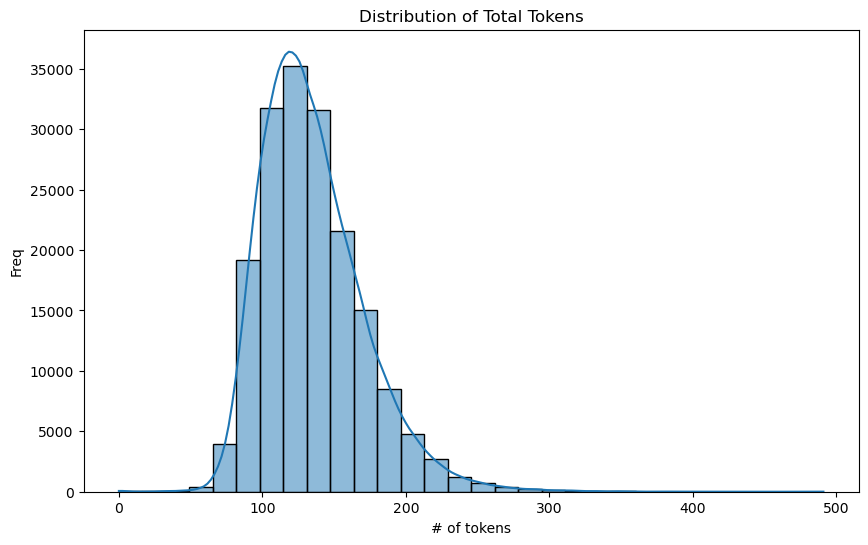

In [11]:
df_dataset['total_tokens'] = df_dataset['mbert_text_tokens'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df_dataset['total_tokens'], bins=30, kde=True)
plt.title('Distribution of Total Tokens')
plt.xlabel('# of tokens')
plt.ylabel('Freq')
plt.show()

In [14]:
%%time
df_dataset['token_index'] = df_dataset['mbert_text_tokens'].apply(lambda x: list(range(len(x))))

# Explode the lists in each column, keep track of the original index and list index values
df_tokens = df_dataset.set_index('id')[['mbert_text_tokens','mbert_bio_labels', 'token_index']].apply(lambda col: col.explode()).reset_index(drop=False)
df_tokens.columns = ['id', 'token', 'labels', 'token_index']
df_tokens

CPU times: total: 7.58 s
Wall time: 7.62 s


,id,token,labels,token_index
0,40767A,Sub,O,0
1,40767A,##ject,O,1
2,40767A,:,O,2
3,40767A,Group,O,3
4,40767A,Mess,O,4
...,...,...,...,...
23988197,40766F,##4,I-STATE,134
23988198,40766F,"""",I-STATE,135
23988199,40766F,},I-STATE,136
23988200,40766F,},I-STATE,137


In [15]:
%%timr
ser_value_counts = df_tokens.labels.value_counts()

# # new_index = ser_value_counts.index.map(id2classes)

# # Create a new Series with mapped values
# pd.Series(ser_value_counts.values, index=new_index)
ser_value_counts

UsageError: Cell magic `%%timr` not found.


In [ ]:
plt.figure(figsize=(12,8))
ser_value_counts[1:].plot(kind='barh')

In [ ]:
sns.histplot(df_dataset['language'])

# En Only

In [16]:
df_dataset_en = df_dataset[df_dataset.language == 'English']
df_dataset_en.shape

(29908, 10)

In [17]:
%%time
df_dataset_en['token_index'] = df_dataset_en['mbert_text_tokens'].apply(lambda x: list(range(len(x))))

# Explode the lists in each column, keep track of the original index and list index values
df_tokens_en = df_dataset_en.set_index('id')[['mbert_text_tokens','mbert_bio_labels', 'token_index']].apply(lambda col: col.explode()).reset_index(drop=False)
df_tokens_en.columns = ['id', 'token', 'labels', 'token_index']
df_tokens_en

<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CPU times: total: 1.12 s
Wall time: 1.12 s


,id,token,labels,token_index
0,40767A,Sub,O,0
1,40767A,##ject,O,1
2,40767A,:,O,2
3,40767A,Group,O,3
4,40767A,Mess,O,4
...,...,...,...,...
3794832,53617C,##ty,O,88
3794833,53617C,of,O,89
3794834,53617C,the,O,90
3794835,53617C,profession,O,91


In [18]:
ser_value_counts = df_tokens_en.labels.value_counts()

# # new_index = ser_value_counts.index.map(id2classes)

# # Create a new Series with mapped values
# pd.Series(ser_value_counts.values, index=new_index)
ser_value_counts

labels
O                  2848246
I-IP                116577
I-EMAIL              84176
I-DRIVERLICENSE      53613
I-USERNAME           51361
I-SOCIALNUMBER       44931
I-BOD                42930
I-TEL                41938
I-IDCARD             40946
I-STREET             33819
I-PASSPORT           32038
I-CITY               29652
I-DATE               26820
I-TIME               25783
I-LASTNAME1          23556
I-PASS               21866
I-GIVENNAME1         17272
I-POSTCODE           16269
I-SEX                14427
I-TITLE              13278
B-TIME               12183
I-COUNTRY            11535
B-USERNAME           10144
I-SECADDRESS         10012
B-EMAIL               9124
B-SOCIALNUMBER        8738
B-IDCARD              8667
B-PASSPORT            8115
B-DRIVERLICENSE       7967
B-BOD                 7740
B-IP                  7692
B-LASTNAME1           7519
B-GIVENNAME1          6836
B-SEX                 6674
B-TEL                 6671
B-TITLE               6668
I-STATE              

<Axes: ylabel='labels'>

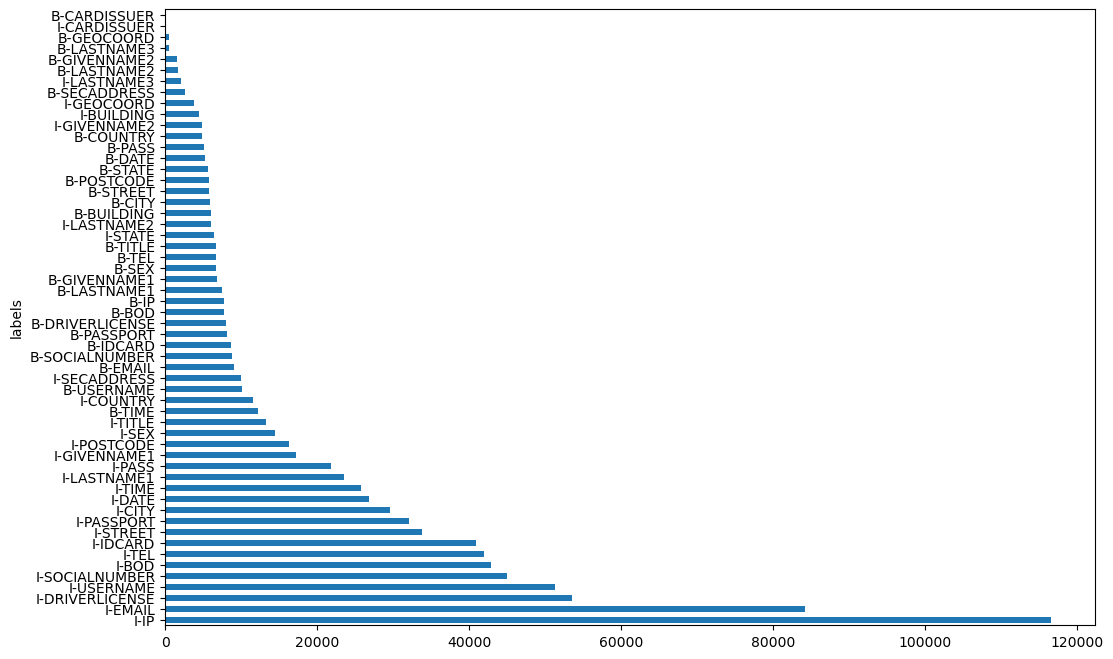

In [19]:
plt.figure(figsize=(12,8))
ser_value_counts[1:].plot(kind='barh')

# Initialize

In [24]:
tokenizer = AutoTokenizer.from_pretrained("Yanis/microsoft-deberta-v3-large_ner_conll2003-anonimization_TRY_1")

# Code

In [20]:
def visualize_span(cur_text, span_infos, nlp = None):

    if not nlp:
        nlp = spacy.load("en_core_web_sm")
        
    doc = nlp(cur_text)

    list_span = []

    for span_info in span_infos:
        start = span_info['start']
        end = span_info['end']
        label = span_info['label']
        span = doc.char_span(start, end, label=label, alignment_mode = 'expand')

        if span == None:
            print('isnone')
        else:
            list_span.append(span)

    doc.ents = list_span

    # Visualize the annotated text with labels
    # options = {"colors": {"USERNAME": "yellow"}}
    # displacy.render(doc, style="ent", options=options)
    displacy.render(doc, style="ent")

In [21]:
def catch_return(return_value=pd.NA):
    def wrapper(func):
        def wrapped_function(row, *args, **kwargs):
            try:
                return func(row, *args, **kwargs)
            except Exception as e:
                print(f"An error occurred at index {row.name}: {e}")
                return return_value
        return wrapped_function
    return wrapper

In [22]:
@catch_return(return_value=[])
def spans_to_labels(row, tokenizer):
    
    cur_text = row.source_text
    span_infos = row.privacy_mask 
    
    token_infos = tokenizer(cur_text, return_offsets_mapping=True)
    
    token_infos['start'], token_infos['end'] = zip(*token_infos['offset_mapping'])
    
    token_labels = ['O']*len(token_infos['start'])

    i_token = 0

    #Initializee start token

    token_info = token_infos[0]

    for span_info in span_infos:
        skip_span = False

        #Update latest token

        #Skip condition ('C1') 
        while token_infos['end'][i_token] < span_info['start']:
            i_token += 1

        #condition('C2')
        #Handle leading whitespace at postprocessing (During token to words -> remove labels from whitespace)
        ##Example: Token entry 0, token 52  (might be important to model (_ -> ' ')
        while token_infos['start'][i_token] < span_info['start']:

            #('C2.5')
            if token_infos['end'][i_token] > span_info['end']:
                print('C2.5')
                i_token += 1
                skip_span = True

            #('C2')
            else:
                token_labels[i_token] = span_info['label']
                i_token += 1

        if skip_span:
            continue
            
        #Condition ('C3') - assign label
        # C3 start: token_info['start'] >= span_info['start']
        # C3 End:  token_info['end'] <= span_info['end']
        # print(i_token)  # Debug
        while token_infos['start'][i_token] >= span_info['start'] and token_infos['end'][i_token] <= span_info['end']:
            token_labels[i_token] = span_info['label']
            i_token +=1
            
    return token_labels[1:-1]

## Test

In [25]:
cur_sample = df_dataset.loc[0]

cur_text = cur_sample.source_text
span_infos = cur_sample.privacy_mask 
token_infos = tokenizer(cur_text, return_offsets_mapping=True)

token_infos['start'], token_infos['end'] = zip(*token_infos['offset_mapping'])

In [26]:
new_labels = spans_to_labels(cur_sample, tokenizer)

### From Span

In [27]:
visualize_span(cur_sample.source_text, cur_sample.privacy_mask)

### Span to Labels

In [28]:
cur_tokens = tokenizer.tokenize(cur_text)
nlp = spacy.load("en_core_web_sm")
doc = Doc(nlp.vocab, words=cur_tokens)
visualize_label(nlp, doc, cur_tokens, new_labels, options=options_pii)

### From Orig Labels

In [29]:
cur_tokens = cur_sample['mbert_text_tokens']
cur_token_labels = cur_sample.mbert_bio_labels

nlp = spacy.load("en_core_web_sm")
doc = Doc(nlp.vocab, words=cur_tokens)
visualize_label(nlp, doc, cur_tokens, cur_token_labels, options = options_pii)

# Preprocess

## Convert Spans to Labels

In [30]:
len(df_dataset)

177677

In [31]:
%%time

#4.66s per 10,000 entries | 1min 44s for whole dataset
temp_ser_labels = df_dataset.loc[:10000].apply(lambda row: spans_to_labels(row, tokenizer), axis=1)

# df_dataset_en['deberta_labels'] = df_dataset.apply(lambda row: spans_to_labels(row, tokenizer), axis=1)

An error occurred at index 43: tuple index out of range
An error occurred at index 47: tuple index out of range
An error occurred at index 648: tuple index out of range
An error occurred at index 1101: tuple index out of range
An error occurred at index 1393: tuple index out of range
An error occurred at index 1612: tuple index out of range
An error occurred at index 2153: tuple index out of range
An error occurred at index 2791: tuple index out of range
An error occurred at index 2864: tuple index out of range
An error occurred at index 3338: tuple index out of range
An error occurred at index 4045: tuple index out of range
An error occurred at index 5694: tuple index out of range
An error occurred at index 5695: tuple index out of range
An error occurred at index 5972: tuple index out of range
An error occurred at index 6466: tuple index out of range
An error occurred at index 7241: tuple index out of range
An error occurred at index 7364: tuple index out of range
An error occurred a

<timed exec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [32]:
%%time
df_dataset_en['deberta_tokens'] = df_dataset_en.apply(lambda row: tokenizer.tokenize(row.source_text), axis=1)

CPU times: total: 13.6 s
Wall time: 13.7 s


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [33]:
temp_ser_labels

NameError: name 'temp_ser_labels' is not defined

In [ ]:
df_dataset.loc[:10000, 'label'] = temp_ser_labels

In [ ]:
temp_ser_labels

## To BIO Labels

Implement naive ver (string based)
 - From spans 
 - From non-BIO labels 
   - does not handle case of consecutive same entity type
     - will be handled as same entity
     
Implement ver with adapter for to_bio_vect
test
Compare performance

### References

In [36]:
def align_words(tokens, words, word_ids, labels):
    
    #word to tokens
    token_labels = []
    prev_entity = None
    prev_ent_type = None
    
    # Step 5: Iterate through pairs of words and subwords to count the majority label
    for i, (word_id, token) in enumerate(zip(word_ids, tokens)):
        if word_id is None:
            token_labels.append('O')
#             continue
        else:
            
            try:
                token_label = labels[word_id]
            except Exception as e: # Temp error checking
                print(word_id)
                print(len(labels))
                
                raise(e)
                
            #Outside
            if token_label == 'O':
                token_labels.append('O')
                ent_type = 'O'
                
            else:
                prefix, ent_type = token_label.split('-')
            
                #Same entity: B-ent:B-ent, I-ent,I-ent, B-ent,I-ent
                if prev_entity == token_label or f'I-{prev_ent_type}' == token_label:
                    token_labels.append(f'I-{prev_ent_type}')  

                #New Entity: I-ent: B-ent, x-ent1: x-ent2\
                else:
                    token_labels.append(f'B-{ent_type}')

            prev_entity = token_labels
            prev_ent_type = ent_type

In [37]:
def to_bio_vect(np_pred_words, np_model_id2cur_entity_id = np_class_id2entity_id):
#     global cumsum, out, zeros, change_indices, accumulate, diff_array, b_mask_indices, i_mask_indices, b_words, i_words, b_words_mapped, i_words_mapped
    
    np_pred_words = np_model_id2cur_entity_id[np_pred_words]

    diff_array = np.diff(np_pred_words, axis=-1, prepend=-1)
    change_indices = np.where(diff_array!=0, 0, 1)
    zeros = change_indices == 0 #reverse of change_indices
    cumsum = np.cumsum(change_indices, axis=-1)
    accumulate = np.maximum.accumulate(np.where(zeros, cumsum, 0), axis=-1)
    out = cumsum - accumulate
    b_mask = out == 0
    b_mask_indices = np.where(b_mask)
    i_mask_indices = np.where(~b_mask)
    
    np_pred_words_mapped = np.empty_like(np_pred_words)
    
    b_words = np_pred_words[b_mask_indices]
    i_words = np_pred_words[i_mask_indices]
    
    b_words_mapped = np_entity_id2class_id_b[b_words]
    i_words_mapped = np_entity_id2class_id_i[i_words]
    
    np_pred_words_mapped[b_mask_indices] = b_words_mapped
    np_pred_words_mapped[i_mask_indices] = i_words_mapped
    
    return np_pred_words_mapped


### From Span

In [38]:
def attach_prefix(label, is_beginning = True):
    
    if is_beginning:
        return f'B-{label}'
        
    else:
        return f'I-{label}'
        


@catch_return(return_value=[])
def spans_to_labels(row, tokenizer, return_bio = False):
    
    cur_text = row.source_text
    span_infos = row.privacy_mask 
    
    token_infos = tokenizer(cur_text, return_offsets_mapping=True)
    
    token_infos['start'], token_infos['end'] = zip(*token_infos['offset_mapping'])
    
    token_labels = ['O']*len(token_infos['start'])
    token_labels_bio = ['O']*len(token_infos['start'])

    i_token = 0

    #Initializee start token

    token_info = token_infos[0]

    for span_info in span_infos:
        skip_span = False
        is_beginning = True

        #Update latest token

        #Skip condition ('C1') 
        while token_infos['end'][i_token] < span_info['start']:
            i_token += 1

        #condition('C2')
        #Handle leading whitespace at postprocessing (During token to words -> remove labels from whitespace)
        ##Example: Token entry 0, token 52  (might be important to model (_ -> ' ')
        while token_infos['start'][i_token] < span_info['start']:

            #('C2.5')
            if token_infos['end'][i_token] > span_info['end']:
                print('C2.5')
                i_token += 1
                skip_span = True

            #('C2')
            else:
                token_labels[i_token] = span_info['label']
                token_labels_bio[i_token] = attach_prefix(span_info['label'], is_beginning)
                i_token += 1
                is_beginning = False

        if skip_span:
            continue
            
        #Condition ('C3') - assign label
        # C3 start: token_info['start'] >= span_info['start']
        # C3 End:  token_info['end'] <= span_info['end']
        # print(i_token)  # Debug
        
        
        while token_infos['start'][i_token] >= span_info['start'] and token_infos['end'][i_token] <= span_info['end']:
            token_labels[i_token] = span_info['label']
            token_labels_bio[i_token] = attach_prefix(span_info['label'], is_beginning)
            i_token +=1
            is_beginning = False
            
            
    if return_bio:
        return token_labels_bio[1:-1]
    
    else:
        return token_labels[1:-1]

#### Run

In [39]:
temp_ser_labels = df_dataset.loc[:10].apply(lambda row: spans_to_labels(row, tokenizer, return_bio=True), axis=1)

In [40]:
temp_ser_labels

0     [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...
1     [O, O, O, B-TIME, I-TIME, I-TIME, I-TIME, O, B...
2     [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...
3     [O, O, B-IDCARD, I-IDCARD, I-IDCARD, I-IDCARD,...
4     [O, O, O, O, O, O, O, O, O, O, B-PASS, I-PASS,...
5     [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...
6     [O, O, O, O, O, O, O, B-SOCIALNUMBER, I-SOCIAL...
7     [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...
8     [O, O, O, O, O, B-BOD, I-BOD, I-BOD, I-BOD, B-...
9     [O, O, O, O, O, O, O, O, O, O, O, O, B-BOD, I-...
10    [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...
dtype: object

In [41]:
%%time
df_dataset_en['deberta_labels_bio'] = df_dataset_en.apply(lambda row: spans_to_labels(row, tokenizer, return_bio=True), axis=1)

An error occurred at index 43: tuple index out of range
An error occurred at index 47: tuple index out of range
An error occurred at index 648: tuple index out of range
An error occurred at index 1101: tuple index out of range
An error occurred at index 1393: tuple index out of range
An error occurred at index 1612: tuple index out of range
An error occurred at index 2153: tuple index out of range
An error occurred at index 2791: tuple index out of range
An error occurred at index 2864: tuple index out of range
An error occurred at index 3338: tuple index out of range
An error occurred at index 4045: tuple index out of range
An error occurred at index 5694: tuple index out of range
An error occurred at index 5695: tuple index out of range
An error occurred at index 5972: tuple index out of range
An error occurred at index 6466: tuple index out of range
An error occurred at index 7241: tuple index out of range
An error occurred at index 7364: tuple index out of range
An error occurred a

<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [42]:
%%time
# df_dataset_en = df_dataset_en.rename(columns={'deberta_tokens_bio': "deberta_labels_bio"})

CPU times: total: 0 ns
Wall time: 0 ns


### From Label

# Filter Data

Main Goal:
 - Reduce remaining FP and FN for the following classes:
   - B-Email
   - B-ID_NUM
   - I-Phone_NUM
   - I-Name_STUDENT

Data Needed:
 - B-Email
   - Email
 - B-ID_NUM (Need to inspect properties of data from original dataset)
   - SocialNumber
   - Drivers License
   - passport
 - I-Phone_NUM (Need to inspect properties of data from original dataset)
   - Tel (Need to inspect and determine how to breakdown to BIO)
 - I-Name_STUDENT (Need to inspect and determine how to breakdown to BIO)
   - LASTNAME1/2/3
   - GIVENNAME2/3?

Future Goals:
 1. Raise recall for address related classes

Others:
 1. Debug cause of I-NAME_STUDENT FP and FN results
   - Check entries where model failed
   - Check interaction with to_bio (results with or without)

## Code

In [43]:
def count_row_labels(row, label, label_col = 'deberta_labels'):
    
    counts = Counter(row[label_col])[label]
    return counts

In [69]:
df_dataset_en['deberta_tokens_len'] = df_dataset_en['deberta_tokens'].apply(len)
df_dataset_en['count_O'] = df_dataset_en.apply(lambda row: count_row_labels(row, 'O', label_col='deberta_labels_bio'), axis=1)
df_dataset_en['density_O'] = df_dataset_en.apply(lambda row: row.count_O / row.deberta_tokens_len, axis=1)

C:\Users\cloud\AppData\Local\Temp\ipykernel_15368\779489231.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dataset_en['deberta_tokens_len'] = df_dataset_en['deberta_tokens'].apply(len)
C:\Users\cloud\AppData\Local\Temp\ipykernel_15368\779489231.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dataset_en['count_O'] = df_dataset_en.apply(lambda row: count_row_labels(row, 'O', label_col='deberta_labels_bio'), axis=1)
C:\Users\cloud\AppData\Local\Temp\ipykernel_15368\779489231.py:3: SettingWithCop

## Email

In [44]:
df_dataset_en.head()

,source_text,target_text,privacy_mask,span_labels,mbert_text_tokens,mbert_bio_labels,id,language,set,token_index,deberta_labels,deberta_tokens,deberta_labels_bio
0,Subject: Group Messaging for Admissions Proces...,Subject: Group Messaging for Admissions Proces...,"[{'value': 'wynqvrh053', 'start': 287, 'end': ...","[[440, 453, ""USERNAME""], [430, 437, ""TIME""], [...","[Sub, ##ject, :, Group, Mess, ##aging, for, Ad...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",40767A,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[▁Subject, :, ▁Group, ▁Messaging, ▁for, ▁Admis...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,- Meeting at 2:33 PM\n- N23 - Meeting at 11:29...,- Meeting at [TIME]\n- [USERNAME] - Meeting at...,"[{'value': '2:33 PM', 'start': 13, 'end': 20, ...","[[74, 81, ""TIME""], [50, 60, ""USERNAME""], [40, ...","[-, Meeting, at, 2, :, 33, PM, -, N, ##23, -, ...","[O, O, O, B-TIME, I-TIME, I-TIME, I-TIME, O, O...",40767B,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[O, O, O, TIME, TIME, TIME, TIME, O, USERNAME,...","[▁-, ▁Meeting, ▁at, ▁2, :, 33, ▁PM, ▁-, ▁N, 23...","[O, O, O, B-TIME, I-TIME, I-TIME, I-TIME, O, B..."
2,Subject: Admission Notification - Great Britai...,Subject: Admission Notification - Great Britai...,"[{'value': '5:24am', 'start': 263, 'end': 269,...","[[395, 407, ""SOCIALNUMBER""], [358, 375, ""EMAIL...","[Sub, ##ject, :, Ad, ##mission, Not, ##ificati...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",40768A,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[▁Subject, :, ▁Admission, ▁Notification, ▁-, ▁...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,Card: KB90324ER\n Country: GB\n Building: ...,Card: [IDCARD]\n Country: [COUNTRY]\n Buil...,"[{'value': 'KB90324ER', 'start': 6, 'end': 15,...","[[390, 393, ""STATE""], [368, 378, ""CITY""], [346...","[Card, :, KB, ##90, ##32, ##4, ##ER, \, n, Cou...","[O, O, B-IDCARD, I-IDCARD, I-IDCARD, I-IDCARD,...",40768B,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[O, O, IDCARD, IDCARD, IDCARD, IDCARD, O, O, O...","[▁Card, :, ▁KB, 903, 24, ER, \, n, ▁Country, :...","[O, O, B-IDCARD, I-IDCARD, I-IDCARD, I-IDCARD,..."
4,"N, WA14 5RW\n Password: r]iD1#8\n\n...and so...","N, WA14 5RW\n Password: [PASS]\n\n...and so ...","[{'value': 'r]iD1#8', 'start': 26, 'end': 33, ...","[[336, 352, ""DATE""], [26, 33, ""PASS""]]","[N, ,, W, ##A, ##14, 5, ##R, ##W, \, n, Pass, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-PASS...",40768C,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[O, O, O, O, O, O, O, O, O, O, PASS, PASS, PAS...","[▁N, ,, ▁WA, 14, ▁5, RW, \, n, ▁Password, :, ▁...","[O, O, O, O, O, O, O, O, O, O, B-PASS, I-PASS,..."


In [49]:
cur_sample = df_dataset_en.loc[0]

In [50]:
counts = Counter(cur_sample['deberta_labels'])['B-EMAIL']

In [51]:
Counter(cur_sample['deberta_labels'])

Counter({'O': 68, 'USERNAME': 33, 'TIME': 12})

In [52]:
count_row_labels(cur_sample, 'B-EMAIL')

0

In [53]:
%%time
df_dataset_en['count_B-EMAIL'] = df_dataset_en.apply(lambda row: count_row_labels(row, 'B-EMAIL', label_col='deberta_labels_bio'), axis=1)

CPU times: total: 625 ms
Wall time: 634 ms


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [55]:
df_dataset_en[df_dataset_en['count_B-EMAIL'] != 0].sort_values('count_B-EMAIL', ascending=False)[:10]

,source_text,target_text,privacy_mask,span_labels,mbert_text_tokens,mbert_bio_labels,id,language,set,token_index,deberta_labels,deberta_tokens,deberta_labels_bio,count_B-EMAIL
10935,w. Engage with fellow members such as: \n- shi...,w. Engage with fellow members such as: \n- [US...,"[{'value': 'shion', 'start': 42, 'end': 47, 'l...","[[380, 406, ""EMAIL""], [350, 377, ""EMAIL""], [32...","[w, ., Eng, ##age, with, fellow, members, such...","[O, O, O, O, O, O, O, O, O, O, O, B-USERNAME, ...",45510B,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[O, O, O, O, O, O, O, O, O, O, USERNAME, USERN...","[▁w, ., ▁Engage, ▁with, ▁fellow, ▁members, ▁su...","[O, O, O, O, O, O, O, O, O, O, B-USERNAME, I-U...",14
499,"@outlook.com, 23MKB@yahoo.com, HBD1994@protonm...","@outlook.com, [EMAIL], [EMAIL], [EMAIL], [EMAI...","[{'value': '23MKB@yahoo.com', 'start': 14, 'en...","[[379, 389, ""DATE""], [353, 370, ""STREET""], [30...","[@, out, ##lo, ##ok, ., com, ,, 23, ##M, ##K, ...","[O, O, O, O, O, O, O, B-EMAIL, I-EMAIL, I-EMAI...",40985C,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[O, O, O, O, O, EMAIL, EMAIL, EMAIL, EMAIL, EM...","[▁@, outlook, ., com, ,, ▁23, M, KB, @, yahoo,...","[O, O, O, O, O, B-EMAIL, I-EMAIL, I-EMAIL, I-E...",13
21930,"zf8435@yahoo.com, R79@aol.com, 27A@hotmail.com...","zf8435@yahoo.com, [EMAIL], [EMAIL], [EMAIL], [...","[{'value': 'R79@aol.com', 'start': 18, 'end': ...","[[460, 474, ""IP""], [451, 458, ""CITY""], [432, 4...","[z, ##f, ##8, ##43, ##5, @, ya, ##ho, ##o, ., ...","[O, O, O, O, O, O, O, O, O, O, O, O, B-EMAIL, ...",50212C,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[O, O, O, O, O, O, O, O, O, EMAIL, EMAIL, EMAI...","[▁z, f, 84, 35, @, yahoo, ., com, ,, ▁R, 79, @...","[O, O, O, O, O, O, O, O, O, B-EMAIL, I-EMAIL, ...",13
15645,"mails"": [""emilita.potalivo@tutanota.com"", ""mal...","mails"": [""[EMAIL]"", ""[EMAIL]"", ""[EMAIL]"", ""[EM...","[{'value': 'emilita.potalivo@tutanota.com', 's...","[[354, 360, ""TIME""], [307, 321, ""DATE""], [248,...","[mail, ##s, "", :, [, "", em, ##ili, ##ta, ., po...","[O, O, O, O, O, O, B-EMAIL, I-EMAIL, I-EMAIL, ...",47480B,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[O, O, O, O, EMAIL, EMAIL, EMAIL, EMAIL, EMAIL...","[▁mails, "", :, ▁[, "", emi, lita, ., pot, al, i...","[O, O, O, O, B-EMAIL, I-EMAIL, I-EMAIL, I-EMAI...",11
18811,"3.945 9534, Shermine, Leich, Kehagias.\n \n3....","3.945 9534, [GIVENNAME1], [LASTNAME1], [LASTNA...","[{'value': 'Shermine', 'start': 12, 'end': 20,...","[[351, 358, ""STREET""], [301, 319, ""EMAIL""], [2...","[3, ., 945, 953, ##4, ,, She, ##rmin, ##e, ,, ...","[O, O, O, O, O, O, B-GIVENNAME1, I-GIVENNAME1,...",48851B,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[O, O, O, O, O, O, GIVENNAME1, GIVENNAME1, O, ...","[▁3, ., 945, ▁95, 34, ,, ▁Sher, mine, ,, ▁Le, ...","[O, O, O, O, O, O, B-GIVENNAME1, I-GIVENNAME1,...",11
16106,"mail: ""G@hotmail.com""\n - Email: ""zoubaïkor...","mail: ""[EMAIL]""\n - Email: ""[EMAIL]""\n -...","[{'value': 'G@hotmail.com', 'start': 7, 'end':...","[[378, 404, ""EMAIL""], [351, 362, ""EMAIL""], [30...","[mail, :, "", G, @, hot, ##mail, ., com, "", -, ...","[O, O, O, B-EMAIL, I-EMAIL, I-EMAIL, I-EMAIL, ...",47682D,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[O, O, EMAIL, EMAIL, EMAIL, EMAIL, EMAIL, EMAI...","[▁mail, :, ▁"", G, @, hotmail, ., com, "", ▁-, ▁...","[O, O, B-EMAIL, I-EMAIL, I-EMAIL, I-EMAIL, I-E...",11
9274,"""mghkhnujzv226524@protonmail.com"",\n ...","""[EMAIL]"",\n ""[EMAIL]"",\n ...","[{'value': 'mghkhnujzv226524@protonmail.com', ...","[[483, 491, ""TIME""], [391, 412, ""EMAIL""], [345...","["", mg, ##h, ##kh, ##nu, ##j, ##z, ##v, ##22, ...","[O, B-EMAIL, I-EMAIL, I-EMAIL, I-EMAIL, I-EMAI...",44798C,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[EMAIL, EMAIL, EMAIL, EMAIL, EMAIL, EMAIL, EMA...","[▁"", m, gh, kh, nu, jz, v, 226, 524, @, proton...","[B-EMAIL, I

### Most counts

In [57]:
cur_sample = df_dataset_en.loc[21274]

cur_tokens = cur_sample.deberta_tokens
cur_labels = cur_sample.deberta_labels_bio

nlp = spacy.load("en_core_web_sm")
doc = Doc(nlp.vocab, words=cur_tokens)
visualize_label(nlp, doc, cur_tokens, cur_labels, options=options_pii)

In [58]:
visualize_span(cur_sample.source_text, cur_sample.privacy_mask)

### Less counts

In [60]:
df_dataset_en[df_dataset_en['count_B-EMAIL'] != 0].sort_values('count_B-EMAIL', ascending=True)[:10]

,source_text,target_text,privacy_mask,span_labels,mbert_text_tokens,mbert_bio_labels,id,language,set,token_index,deberta_labels,deberta_tokens,deberta_labels_bio,count_B-EMAIL
2,Subject: Admission Notification - Great Britai...,Subject: Admission Notification - Great Britai...,"[{'value': '5:24am', 'start': 263, 'end': 269,...","[[395, 407, ""SOCIALNUMBER""], [358, 375, ""EMAIL...","[Sub, ##ject, :, Ad, ##mission, Not, ##ificati...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",40768A,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[▁Subject, :, ▁Admission, ▁Notification, ▁-, ▁...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",1
17881,"me"": ""Slatinská""\n },\n {\n ...","me"": ""[LASTNAME2]""\n },\n {\n ...","[{'value': 'Slatinská', 'start': 6, 'end': 15,...","[[325, 343, ""USERNAME""], [269, 277, ""LASTNAME1...","[me, "", :, "", S, ##lati, ##nská, "", }, ,, {, ""...","[O, O, O, O, B-LASTNAME2, I-LASTNAME2, I-LASTN...",48449B,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[O, O, O, LASTNAME2, LASTNAME2, LASTNAME2, LAS...","[▁me, "", :, ▁"", S, latin, ská, "", ▁}, ,, ▁{, ▁...","[O, O, O, B-LASTNAME2, I-LASTNAME2, I-LASTNAME...",1
17880,"{\n""Time Efficiency Assessment"": {\n ""Parti...","{\n""Time Efficiency Assessment"": {\n ""Parti...","[{'value': 'valdir26', 'start': 91, 'end': 99,...","[[310, 315, ""LASTNAME1""], [266, 281, ""IP""], [2...","[{, "", Time, E, ##ffi, ##cie, ##ncy, Assessmen...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",48449A,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[▁{, ▁"", Time, ▁Efficiency, ▁Assessment, "", :,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",1
17869,eatures and Benefits:**\n\n1. **P@aol.com**\n ...,eatures and Benefits:**\n\n1. **[EMAIL]**\n ...,"[{'value': 'P@aol.com', 'start': 30, 'end': 39...","[[371, 383, ""SOCIALNUMBER""], [353, 362, ""PASSP...","[eat, ##ures, and, Ben, ##ef, ##its, :, *, *, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",48445B,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[O, O, O, O, O, O, O, O, O, O, EMAIL, EMAIL, E...","[▁eat, ures, ▁and, ▁Benefits, :, *, *, ▁1, ., ...","[O, O, O, O, O, O, O, O, O, O, B-EMAIL, I-EMAI...",1
17865,```xml\n<ResidenceHallInspectionReport>\n <...,```xml\n<ResidenceHallInspectionReport>\n <...,"[{'value': 'DM@yahoo.com', 'start': 95, 'end':...","[[392, 402, ""CITY""], [342, 359, ""STREET""], [30...","[[UNK], [UNK], [UNK], x, ##ml, <, Res, ##iden,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",48444A,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[▁`, `, `, xml, ▁<, Residence, Hall, In, spect...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",1
17850,"{\n\t""Maintenance_Request_Form"": {\n\t\t""Reque...","{\n\t""Maintenance_Request_Form"": {\n\t\t""Reque...","[{'value': 'denisa-maria.beimler@yahoo.com', '...","[[459, 470, ""DATE""], [443, 445, ""STATE""], [383...","[{, "", Main, ##tena, ##nce, _, Re, ##quest, _,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",48436,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[▁{, ▁"", Maintenance, _, Request, _, Form, "", ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",1
17843,"lijete.reverchon@aol.com\nDate: September 16, ...","lijete.reverchon@aol.com\nDate: September 16, ...","[{'value': 'etan@protonmail.com', 'start': 319...","[[319, 338, ""EMAIL""]]","[li, ##jete, ., rev, ##er, ##chon, @, ao, ##l,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",48433B,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[▁li, jet, e, ., re, ver, chon, @, aol, ., com...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",1
17882,"""Email"": ""

In [63]:
cur_sample = df_dataset_en.loc[17850]

cur_tokens = cur_sample.deberta_tokens
cur_labels = cur_sample.deberta_labels_bio

nlp = spacy.load("en_core_web_sm")
doc = Doc(nlp.vocab, words=cur_tokens)
visualize_label(nlp, doc, cur_tokens, cur_labels, options=options_pii)

In [64]:
visualize_span(cur_sample.source_text, cur_sample.privacy_mask)

### 'O' density

Goal: more natural text  / paragraph/sentence form | not enumeration
Properties
 - More 'O' labels
 - Less positive labels
 - containing at least 1 of the desired label
 - O_density = count_o / len(total)
 
Filter:
 - O_density > o_dens_threshold
 - count_label >= 1


In [73]:
df_dataset_en[df_dataset_en['count_B-EMAIL'] >= 1].sort_values('count_B-EMAIL', ascending=True)[:10]

,source_text,target_text,privacy_mask,span_labels,mbert_text_tokens,mbert_bio_labels,id,language,set,token_index,deberta_labels,deberta_tokens,deberta_labels_bio,count_B-EMAIL,deberta_tokens_len,count_O,density_O
2,Subject: Admission Notification - Great Britai...,Subject: Admission Notification - Great Britai...,"[{'value': '5:24am', 'start': 263, 'end': 269,...","[[395, 407, ""SOCIALNUMBER""], [358, 375, ""EMAIL...","[Sub, ##ject, :, Ad, ##mission, Not, ##ificati...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",40768A,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[▁Subject, :, ▁Admission, ▁Notification, ▁-, ▁...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",1,113,87,0.769912
17881,"me"": ""Slatinská""\n },\n {\n ...","me"": ""[LASTNAME2]""\n },\n {\n ...","[{'value': 'Slatinská', 'start': 6, 'end': 15,...","[[325, 343, ""USERNAME""], [269, 277, ""LASTNAME1...","[me, "", :, "", S, ##lati, ##nská, "", }, ,, {, ""...","[O, O, O, O, B-LASTNAME2, I-LASTNAME2, I-LASTN...",48449B,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[O, O, O, LASTNAME2, LASTNAME2, LASTNAME2, LAS...","[▁me, "", :, ▁"", S, latin, ská, "", ▁}, ,, ▁{, ▁...","[O, O, O, B-LASTNAME2, I-LASTNAME2, I-LASTNAME...",1,110,56,0.509091
17880,"{\n""Time Efficiency Assessment"": {\n ""Parti...","{\n""Time Efficiency Assessment"": {\n ""Parti...","[{'value': 'valdir26', 'start': 91, 'end': 99,...","[[310, 315, ""LASTNAME1""], [266, 281, ""IP""], [2...","[{, "", Time, E, ##ffi, ##cie, ##ncy, Assessmen...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",48449A,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[▁{, ▁"", Time, ▁Efficiency, ▁Assessment, "", :,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",1,107,61,0.570093
17869,eatures and Benefits:**\n\n1. **P@aol.com**\n ...,eatures and Benefits:**\n\n1. **[EMAIL]**\n ...,"[{'value': 'P@aol.com', 'start': 30, 'end': 39...","[[371, 383, ""SOCIALNUMBER""], [353, 362, ""PASSP...","[eat, ##ures, and, Ben, ##ef, ##its, :, *, *, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",48445B,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[O, O, O, O, O, O, O, O, O, O, EMAIL, EMAIL, E...","[▁eat, ures, ▁and, ▁Benefits, :, *, *, ▁1, ., ...","[O, O, O, O, O, O, O, O, O, O, B-EMAIL, I-EMAI...",1,197,89,0.451777
17865,```xml\n<ResidenceHallInspectionReport>\n <...,```xml\n<ResidenceHallInspectionReport>\n <...,"[{'value': 'DM@yahoo.com', 'start': 95, 'end':...","[[392, 402, ""CITY""], [342, 359, ""STREET""], [30...","[[UNK], [UNK], [UNK], x, ##ml, <, Res, ##iden,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",48444A,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[▁`, `, `, xml, ▁<, Residence, Hall, In, spect...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",1,100,65,0.650000
17850,"{\n\t""Maintenance_Request_Form"": {\n\t\t""Reque...","{\n\t""Maintenance_Request_Form"": {\n\t\t""Reque...","[{'value': 'denisa-maria.beimler@yahoo.com', '...","[[459, 470, ""DATE""], [443, 445, ""STATE""], [383...","[{, "", Main, ##tena, ##nce, _, Re, ##quest, _,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",48436,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[▁{, ▁"", Maintenance, _, Request, _, Form, "", ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",1,184,123,0.668478
17843,"lijete.reverchon@aol.com\nDate: September 16, ...","lijete.reverchon@aol.com\nDate: September 16, ...","[{'value': 'etan@protonmail.com', 'start': 319...","[[319, 338, ""EMAIL""]]","[li, ##jete, ., rev, ##er, ##chon, @, ao, ##l,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",48433B,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, 

In [104]:
df_sorted = df_dataset_en[(df_dataset_en['density_O'] >= 0.7) & (df_dataset_en['count_B-EMAIL'] >= 1)]
print(df_sorted.shape)
df_sorted.head()

(2151, 17)


,source_text,target_text,privacy_mask,span_labels,mbert_text_tokens,mbert_bio_labels,id,language,set,token_index,deberta_labels,deberta_tokens,deberta_labels_bio,count_B-EMAIL,deberta_tokens_len,count_O,density_O
2,Subject: Admission Notification - Great Britai...,Subject: Admission Notification - Great Britai...,"[{'value': '5:24am', 'start': 263, 'end': 269,...","[[395, 407, ""SOCIALNUMBER""], [358, 375, ""EMAIL...","[Sub, ##ject, :, Ad, ##mission, Not, ##ificati...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",40768A,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[▁Subject, :, ▁Admission, ▁Notification, ▁-, ▁...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",1,113,87,0.769912
30,"""4:00 PM""\n }\n ],\n ""locatio...","""4:00 PM""\n }\n ],\n ""locatio...","[{'value': 'ENG', 'start': 48, 'end': 51, 'lab...","[[296, 312, ""EMAIL""], [162, 165, ""GIVENNAME1""]...","["", 4, :, 00, PM, "", }, ], ,, "", location, "", ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",40782C,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, STATE,...","[▁"", 4, :, 00, ▁PM, "", ▁}, ▁], ,, ▁"", location...","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-STAT...",1,111,98,0.882883
74,fully charged before the session.\n2. Join the...,fully charged before the session.\n2. Join the...,"[{'value': 'support@vrschools.co.uk', 'start':...","[[301, 324, ""EMAIL""]]","[fully, charged, before, the, session, ., \, n...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",40804B,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[▁fully, ▁charged, ▁before, ▁the, ▁session, .,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",1,98,90,0.918367
87,"n: ENG, Street: To be disclosed on registratio...","n: [STATE], Street: To be disclosed on registr...","[{'value': 'ENG', 'start': 3, 'end': 6, 'label...","[[77, 102, ""EMAIL""], [53, 69, ""TEL""], [3, 6, ""...","[n, :, EN, ##G, ,, Street, :, To, be, disc, ##...","[O, O, B-STATE, I-STATE, O, O, O, O, O, O, O, ...",40812B,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[O, O, STATE, O, O, O, O, O, O, O, O, O, O, TE...","[▁n, :, ▁ENG, ,, ▁Street, :, ▁To, ▁be, ▁disclo...","[O, O, B-STATE, O, O, O, O, O, O, O, O, O, O, ...",1,98,79,0.806122
109,<div><h2>Climate Change Adaptation Strategy Pl...,<div><h2>Climate Change Adaptation Strategy Pl...,[{'value': '2005sathurjan.sitaras@outlook.com'...,"[[382, 400, ""DRIVERLICENSE""], [368, 377, ""IDCA...","[<, div, >, <, h, ##2, >, Climate, Change, Ada...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",40820A,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[▁<, div, >, <, h, 2, >, Climate, ▁Change, ▁Ad...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",1,144,118,0.819444


In [85]:
#df_dataset_en[df_dataset_en['density_O'] >= 0.8].sort_values('density_O', ascending=False)[:10]

#### Vis

In [99]:
df_sorted.iloc[500].name

18793

In [100]:
target_index = df_sorted.iloc[800].name

cur_sample = df_dataset_en.loc[target_index]

cur_tokens = cur_sample.deberta_tokens
cur_labels = cur_sample.deberta_labels_bio

nlp = spacy.load("en_core_web_sm")
doc = Doc(nlp.vocab, words=cur_tokens)
visualize_label(nlp, doc, cur_tokens, cur_labels, options=options_pii)

In [101]:
visualize_span(cur_sample.source_text, cur_sample.privacy_mask)

## PHONE_NUMBER / TEL

In [106]:
label_name = 'B-TEL'

In [107]:
%%time
df_dataset_en[f'count_{label_name}'] = df_dataset_en.apply(lambda row: count_row_labels(row, label_name, label_col='deberta_labels_bio'), axis=1)

CPU times: total: 969 ms
Wall time: 971 ms


<timed exec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [109]:
df_sorted = df_dataset_en[df_dataset_en[f'count_{label_name}'] != 0].sort_values(f'count_{label_name}', ascending=False)[:10]
df_sorted

,source_text,target_text,privacy_mask,span_labels,mbert_text_tokens,mbert_bio_labels,id,language,set,token_index,deberta_labels,deberta_tokens,deberta_labels_bio,count_B-EMAIL,deberta_tokens_len,count_O,density_O,count_B-TEL
6446,"""For general emergency assistance, additional...","""For general emergency assistance, additional...","[{'value': '+7121327-6120', 'start': 94, 'end'...","[[454, 457, ""STATE""], [431, 437, ""TIME""], [293...","["", For, general, emergency, assistance, ,, ad...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",43539B,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[▁"", For, ▁general, ▁emergency, ▁assistance, ,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",0,162,61,0.376543,13
28963,"9, Keystone Road, Milaca, MN, 56353-4615\n - ...","9, [STREET], [CITY], [STATE], [POSTCODE]\n - ...","[{'value': 'Keystone Road', 'start': 3, 'end':...","[[420, 431, ""STREET""], [405, 409, ""TIME""], [34...","[9, ,, Keys, ##tone, Road, ,, Mil, ##aca, ,, M...","[O, O, B-STREET, I-STREET, I-STREET, O, B-CITY...",53246B,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[O, O, STREET, STREET, O, CITY, CITY, O, STATE...","[▁9, ,, ▁Keystone, ▁Road, ,, ▁Mila, ca, ,, ▁MN...","[O, O, B-STREET, I-STREET, O, B-CITY, I-CITY, ...",0,168,54,0.321429,12
27574,"e.""\n\nText Messages are sent to:\n1. Barriste...","e.""\n\nText Messages are sent to:\n1. [TITLE]\...","[{'value': 'Barrister', 'start': 35, 'end': 44...","[[362, 377, ""DATE""], [268, 283, ""TEL""], [248, ...","[e, ., "", Text, Message, ##s, are, sent, to, :...","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-TITL...",52670B,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[O, O, O, O, O, O, O, O, O, O, O, TITLE, O, O,...","[▁e, ., "", ▁Text, ▁Messages, ▁are, ▁sent, ▁to,...","[O, O, O, O, O, O, O, O, O, O, O, B-TITLE, O, ...",0,158,56,0.354430,12
21758,ng.\n\n---\n**Coach's Notes:**\n\nClient Conta...,ng.\n\n---\n**Coach's Notes:**\n\nClient Conta...,"[{'value': '+10.98.856 3886', 'start': 53, 'en...","[[319, 326, ""TIME""], [286, 299, ""TEL""], [264, ...","[ng, ., -, -, -, *, *, Coach, ', s, Notes, :, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",50140B,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[▁ng, ., ▁-, -, -, ▁*, *, Coach, ', s, ▁Notes,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",0,231,130,0.562771,12
219,0745-07528798\n - 0003 58.316 0473\n ...,[TEL]\n - [TEL]\n - [TEL]\n ...,"[{'value': '0745-07528798', 'start': 1, 'end':...","[[351, 358, ""TIME""], [310, 320, ""STREET""], [25...","[074, ##5, -, 07, ##52, ##8, ##7, ##9, ##8, -,...","[B-TEL, I-TEL, I-TEL, I-TEL, I-TEL, I-TEL, I-T...",40868B,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[TEL, TEL, TEL, TEL, TEL, TEL, O, TEL, TEL, TE...","[▁07, 45, -, 075, 28, 798, ▁-, ▁000, 3, ▁58, ....","[B-TEL, I-TEL, I-TEL, I-TEL, I-TEL, I-TEL, O, ...",0,112,25,0.223214,11
29526,Ethics_Waiver_Form_id(waiving certain ethical ...,Ethics_Waiver_Form_id(waiving certain ethical ...,"[{'value': '+49 82-063.7662', 'start': 155, 'e...","[[338, 354, ""TEL""], [316, 332, ""TEL""], [298, 3...","[Ethics, _, W, ##ai, ##ver, _, Form, _, id, (,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",53471A,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[▁Ethics, _, Wa, iver, _, Form, _, id, (, wa, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",0,137,49,0.357664,11
19494,\n2. A229304248468 - +5-271-550.7068 - 13 o'cl...,\n2. [DRIVERLICENSE] - [TEL] - [TIME]\n3. [DRI...,"[{'value': 'A229304248468', 'start': 4, 'end':...","[[408, 416, ""TIME""], [393, 405, ""TEL""], [377, ...","[2, ., A2, ##2, ##9, ##30, ##42, ##48, ##46, #...","[O, O, O, B-DRIVERLICENSE, I-DRIVERLICENSE, I-...",49147B,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1

### Most counts

In [110]:
target_index = df_sorted.iloc[0].name

cur_sample = df_dataset_en.loc[target_index]

cur_tokens = cur_sample.deberta_tokens
cur_labels = cur_sample.deberta_labels_bio

nlp = spacy.load("en_core_web_sm")
doc = Doc(nlp.vocab, words=cur_tokens)
visualize_label(nlp, doc, cur_tokens, cur_labels, options=options_pii)

In [111]:
visualize_span(cur_sample.source_text, cur_sample.privacy_mask)

### Less counts

In [116]:
df_sorted = df_dataset_en[df_dataset_en[f'count_{label_name}'] != 0].sort_values(f'count_{label_name}', ascending=True)[:10]
df_sorted

,source_text,target_text,privacy_mask,span_labels,mbert_text_tokens,mbert_bio_labels,id,language,set,token_index,deberta_labels,deberta_tokens,deberta_labels_bio,count_B-EMAIL,deberta_tokens_len,count_O,density_O,count_B-TEL
14605,"1938-240 7872""\n IP: ""55.159.190.24...","1938-240 7872""\n IP: ""[IP]""\n ...","[{'value': '55.159.190.241', 'start': 32, 'end...","[[448, 463, ""GEOCOORD""], [369, 407, ""IP""], [33...","[1938, -, 240, 787, ##2, "", IP, :, "", 55, ., 1...","[O, O, O, O, O, O, O, O, O, O, O, B-IP, I-IP, ...",47057C,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[O, O, O, O, O, O, O, O, IP, IP, IP, IP, IP, I...","[▁1938, -, 240, ▁787, 2, "", ▁IP, :, ▁"", 55, .,...","[O, O, O, O, O, O, O, O, B-IP, I-IP, I-IP, I-I...",0,145,54,0.372414,1
14490,"{\n ""Assessment Report"": {\n ""Diagnosis"": ...","{\n ""Assessment Report"": {\n ""Diagnosis"": ...","[{'value': 'firuz.pauschenwein8', 'start': 88,...","[[371, 373, ""TIME""], [300, 339, ""IP""], [278, 2...","[{, "", Assessment, Report, "", :, {, "", Dia, ##...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",47004A,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[▁{, ▁"", Assessment, ▁Report, "", :, ▁{, ▁"", Di...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",0,138,73,0.528986,1
14491,"""Patient_2"": {\n ""Username"": ""14ke...","""Patient_2"": {\n ""Username"": ""[USE...","[{'value': '14keïla', 'start': 41, 'end': 48, ...","[[360, 369, ""PASSPORT""], [320, 336, ""USERNAME""...","["", Pat, ##ient, _, 2, "", :, {, "", User, ##nam...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",47004B,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[O, O, O, O, O, O, O, O, O, O, O, O, USERNAME,...","[▁"", Patient, _, 2, "", :, ▁{, ▁"", User, name, ...","[O, O, O, O, O, O, O, O, O, O, O, O, B-USERNAM...",0,134,81,0.604478,1
14492,"phone"": ""004.946-495-3377"",\n ""Country""...","phone"": ""[TEL]"",\n ""Country"": ""[COUNTRY...","[{'value': '004.946-495-3377', 'start': 9, 'en...","[[352, 371, ""DATE""], [332, 334, ""BUILDING""], [...","[phone, "", :, "", 004, ., 946, -, 495, -, 337, ...","[O, O, O, O, B-TEL, I-TEL, I-TEL, I-TEL, I-TEL...",47004C,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[O, O, O, TEL, TEL, TEL, TEL, TEL, TEL, TEL, T...","[▁phone, "", :, ▁"", 004, ., 946, -, 495, -, 3, ...","[O, O, O, B-TEL, I-TEL, I-TEL, I-TEL, I-TEL, I...",0,133,70,0.526316,1
25036,- GENDER: [M]\n- EMAIL: [dolamic@hotmail.com]\...,- GENDER: [[SEX]]\n- EMAIL: [[EMAIL]]\n- SOCIA...,"[{'value': 'M', 'start': 11, 'end': 12, 'label...","[[147, 168, ""GEOCOORD""], [114, 129, ""TEL""], [7...","[-, GE, ##ND, ##ER, :, [, M, ], -, EM, ##A, ##...","[O, O, O, O, O, O, B-SEX, O, O, O, O, O, O, O,...",51570B,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[O, O, O, O, SEX, SEX, O, O, O, O, EMAIL, EMAI...","[▁-, ▁G, ENDER, :, ▁[, M, ], ▁-, ▁EMAIL, :, ▁[...","[O, O, O, O, B-SEX, I-SEX, O, O, O, O, B-EMAIL...",1,93,53,0.569892,1
14498,"{\n ""proposal"":{\n ""patient"":{\n ...","{\n ""proposal"":{\n ""patient"":{\n ...","[{'value': 'ljulzicavana@tutanota.com', 'start...","[[433, 436, ""CITY""], [390, 407, ""STREET""], [35...","[{, "", proposal, "", :, {, "", patient, "", :, {,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",47008A,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[▁{, ▁"", proposal, "", :, {, ▁"", patient, "", :,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",1,141,82,0.581560,1
14501,"{\n ""Veteran Benefits Application Form"": {\...","{\n ""Veteran Benefits Application Form"": {\...","[{'value': 'namia.laveissiere19', 'start': 94,...","[[346, 357, ""LASTNAME1""], [278, 317, ""IP""], [2...","[{, "", Ve, ##teran, Ben, ##ef, ##its, Applicat...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",47009A,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1

In [127]:
target_index = df_sorted.iloc[15].name

cur_sample = df_dataset_en.loc[target_index]

cur_tokens = cur_sample.deberta_tokens
cur_labels = cur_sample.deberta_labels_bio

nlp = spacy.load("en_core_web_sm")
doc = Doc(nlp.vocab, words=cur_tokens)
visualize_label(nlp, doc, cur_tokens, cur_labels, options=options_pii)

In [128]:
visualize_span(cur_sample.source_text, cur_sample.privacy_mask)

### 'O' density

Goal: more natural text  / paragraph/sentence form | not enumeration
Properties
 - More 'O' labels
 - Less positive labels
 - containing at least 1 of the desired label
 - O_density = count_o / len(total)
 
Filter:
 - O_density > o_dens_threshold
 - count_label >= 1


In [119]:
df_sorted = df_dataset_en[(df_dataset_en['density_O'] >= 0.7) & (df_dataset_en[f'count_{label_name}'] >= 1)]
print(df_sorted.shape)
df_sorted.head()

(1597, 18)


,source_text,target_text,privacy_mask,span_labels,mbert_text_tokens,mbert_bio_labels,id,language,set,token_index,deberta_labels,deberta_tokens,deberta_labels_bio,count_B-EMAIL,deberta_tokens_len,count_O,density_O,count_B-TEL
11,educational leader with a track record of driv...,educational leader with a track record of driv...,"[{'value': 'Jan 28, 1995', 'start': 211, 'end'...","[[244, 259, ""TEL""], [226, 241, ""USERNAME""], [2...","[educational, leader, with, a, track, record, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",40772D,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[▁educational, ▁leader, ▁with, ▁a, ▁track, ▁re...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",0,80,60,0.750000,1
31,Alajouri\t2033-10-22T00:00:00\tM\t09:30\tA1419...,Alajouri\t2033-10-22T00:00:00\t[SEX]\t[TIME]\t...,"[{'value': 'M', 'start': 29, 'end': 30, 'label...","[[74, 81, ""PASS""], [58, 73, ""TEL""], [55, 57, ""...","[Ala, ##jou, ##ri, 203, ##3, -, 10, -, 22, ##T...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",40784A,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[▁Ala, jour, i, ▁20, 33, -, 10, -, 22, T, 00, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",0,105,80,0.761905,1
32,e your audience.\n---\nSession 1: Understandin...,e your audience.\n---\nSession 1: Understandin...,"[{'value': '471477552', 'start': 113, 'end': 1...","[[348, 363, ""TEL""], [341, 343, ""PASSPORT""], [1...","[e, your, audience, ., -, -, -, Session, 1, :,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",40784B,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[▁e, ▁your, ▁audience, ., ▁-, -, -, ▁Session, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",0,81,69,0.851852,1
33,course goals. This step is crucial for guidin...,course goals. This step is crucial for guidin...,"[{'value': '+31880-385-2406', 'start': 244, 'e...","[[264, 271, ""PASS""], [244, 259, ""TEL""]]","[course, goals, ., This, step, is, crucial, fo...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",40784C,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[▁course, ▁goals, ., ▁This, ▁step, ▁is, ▁cruci...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",0,80,66,0.825000,1
40,"""ID,SOCIALNUMBER,TEL,COMMENTS\n1,777 064 4987,...","""ID,SOCIALNUMBER,TEL,COMMENTS\n1,[SOCIALNUMBER...","[{'value': '777 064 4987', 'start': 33, 'end':...","[[248, 261, ""TEL""], [235, 247, ""SOCIALNUMBER""]...","["", ID, ,, SO, ##CI, ##AL, ##N, ##UM, ##B, ##E...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",40786A,English,train,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[▁"", ID, ,, SOC, IAL, N, UMBER, ,, TEL, ,, COM...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",0,109,80,0.733945,2


#### Vis

In [121]:
target_index = df_sorted.iloc[0].name

cur_sample = df_dataset_en.loc[target_index]

cur_tokens = cur_sample.deberta_tokens
cur_labels = cur_sample.deberta_labels_bio

nlp = spacy.load("en_core_web_sm")
doc = Doc(nlp.vocab, words=cur_tokens)
visualize_label(nlp, doc, cur_tokens, cur_labels, options=options_pii)

In [122]:
visualize_span(cur_sample.source_text, cur_sample.privacy_mask)

In [ ]:
#ID: